# Лабораторная работа №6

## Разработка системы автоматического регулирования с нечетким регулятором

Имея заданный диапазон значений для уровня жидкости и расхода, необходимо построить систему, вычисляющую необходимый приток жидкости в зависимости от конкретно введенных пользователем значений уровня жидкости и расхода

Множествами лингвистических переменных (уровень жидкости, расход и приток) являются:

- «малое значение» (описывается с помощью Z-линейной функции); 
- «среднее значение» (описывается с помощью трапециевидной функции); 
- «большое значение» (описывается помощью S-линейной функции).

Система должна предоставить пользователю возможность ввода:

- параметров Z-линейной функции, трапециевидной функции и S-линейной функции;
- текущих уровня и расхода жидкости в численном виде;
- метода активизации подзаключений: 
    - min-активизация; 
    - prod-активизация; 
    - average-активизация
- метода аккумулирования заключений:
    - классическое объединение;
    - алгебраическое объединение;
    - граничное объединение;
    - драстическое объединение
- метода дефаззификации:
    - метод центра тяжести;
    - метод центра площади;
    - метод левого модального значения; 
    - метод правого модального значения

При выводе система должна отображать числовое значение притока жидкости, графики функций принадлежности антецедентов, графики степеней принадлежности антецедентов и функцию принадлежности консеквента

### Импорт необходимых библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import skfuzzy.control as ctrl

In [3]:
import ipywidgets as widgets

from IPython.display import display, clear_output

### Инициализация исходного состояния системы

База правил системы имеет вид:

| № правила | Антецедент                                     | Консеквент              |
|-----------|-----------------------------------------------|-------------------------|
| 1         | уровень жидкости малый И расход жидкости большой | приток жидкости большой |
| 2         | уровень жидкости малый И расход жидкости средний | приток жидкости большой |
| 3         | уровень жидкости малый И расход жидкости малый  | приток жидкости средний |
| 4         | уровень жидкости средний И расход жидкости большой | приток жидкости большой |
| 5         | уровень жидкости средний И расход жидкости средний | приток жидкости средний |
| 6         | уровень жидкости средний И расход жидкости малый | приток жидкости средний |
| 7         | уровень жидкости большой И расход жидкости большой | приток жидкости средний |
| 8         | уровень жидкости большой И расход жидкости средний | приток жидкости малый   |
| 9         | уровень жидкости большой И расход жидкости малый  | приток жидкости малый   |

Ее мы будем использовать для построения симуляции

Диапазоны значений для уровня жидкости и ее расхода

In [4]:
x_level = np.linspace(1.5, 9, 100)
x_flow = np.linspace(0.08, 0.5, 100)

Инициализация лингвистических переменных

In [5]:
level = ctrl.Antecedent(x_level, 'level')
level['small'] = fuzz.zmf(level.universe, 1.5, 4.0)
level['medium'] = fuzz.trapmf(level.universe, [3.0, 4.0, 5.0, 6.0])
level['large'] = fuzz.smf(level.universe, 5.0, 9.0)

In [6]:
flow = ctrl.Antecedent(x_flow, 'flow')
flow['small'] = fuzz.zmf(flow.universe, 0.08, 0.2)
flow['medium'] = fuzz.trapmf(flow.universe, [0.2, 0.25, 0.35, 0.4])
flow['large'] = fuzz.smf(flow.universe, 0.35, 0.5)

In [7]:
inflow = ctrl.Consequent(np.linspace(0, 1, 100), 'inflow')
inflow['small'] = fuzz.zmf(inflow.universe, 0, 0.3)
inflow['medium'] = fuzz.trapmf(inflow.universe, [0.3, 0.4, 0.6, 0.7])
inflow['large'] = fuzz.smf(inflow.universe, 0.6, 1.0)

Переопределение значений функций принадлежности лингвистических переменных в зависимости от пользовательского ввода (мы не будем переопределять консеквент, оставив его значения как доли от 0 до 1)

In [8]:
def define_membership_functions(level_params, flow_params):
    level['small'] = fuzz.zmf(level.universe, level_params[0], level_params[1])
    level['medium'] = fuzz.trapmf(level.universe, level_params[2:6])
    level['large'] = fuzz.smf(level.universe, level_params[6], level_params[7])
    
    flow['small'] = fuzz.zmf(flow.universe, flow_params[0], flow_params[1])
    flow['medium'] = fuzz.trapmf(flow.universe, flow_params[2:6])
    flow['large'] = fuzz.smf(flow.universe, flow_params[6], flow_params[7])
    
    inflow = ctrl.Consequent(np.linspace(0, 1, 100), 'inflow')
    inflow['small'] = fuzz.zmf(inflow.universe, 0, 0.3)
    inflow['medium'] = fuzz.trapmf(inflow.universe, [0.3, 0.4, 0.6, 0.7])
    inflow['large'] = fuzz.smf(inflow.universe, 0.6, 1.0)
    
    return level, flow, inflow

Отображение графиков функций принадлежности антецедентов

In [9]:
def plot_membership_functions(level_mfs, flow_mfs, current_level, current_flow):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 6))
    ax1.plot(x_level, level['small'].mf, 'b', linewidth=1.5, label='Малый уровень')
    ax1.plot(x_level, level['medium'].mf, 'g', linewidth=1.5, label='Средний уровень')
    ax1.plot(x_level, level['large'].mf, 'r', linewidth=1.5, label='Большой уровень')
    ax1.axvline(x=current_level, color='k', linestyle='--')
    ax1.set_title('Функции принадлежности уровня жидкости')
    ax1.set_xlabel('Уровень жидкости')
    ax1.set_ylabel('Принадлежность')
    ax1.legend()

    ax2.plot(x_flow, flow['small'].mf, 'b', linewidth=1.5, label='Малый расход')
    ax2.plot(x_flow, flow['medium'].mf, 'g', linewidth=1.5, label='Средний расход')
    ax2.plot(x_flow, flow['large'].mf, 'r', linewidth=1.5, label='Большой расход')
    ax2.axvline(x=current_flow, color='k', linestyle='--')
    ax2.set_title('Функции принадлежности расхода жидкости')
    ax2.set_xlabel('Расход жидкости')
    ax2.set_ylabel('Принадлежность')
    ax2.legend()

    plt.tight_layout()
    plt.show()

Пересчет притока жидкости в соответствии с пользовательским вводом

In [10]:
def recalculate_inflow(b):
    global inflow_simulation
    clear_output(True)
    level_params = [level_z_a.value, level_z_b.value, level_trap_a.value, level_trap_b.value, level_trap_c.value, 
                    level_trap_d.value, level_s_a.value, level_s_b.value]
    flow_params = [flow_z_a.value, flow_z_b.value, flow_trap_a.value, flow_trap_b.value, flow_trap_c.value, 
                   flow_trap_d.value, flow_s_a.value, flow_s_b.value]
    
    level, flow, inflow = define_membership_functions(level_params, flow_params)
    inflow_simulation = redefine_simulation(level, flow, inflow, activation_dropdown.value, accumulation_dropdown.value, 
                                     defuzzification_dropdown.value)
        
    update_ui()
    plot_membership_functions(level, flow, current_level.value, current_flow.value)
    
    plot_fuzzy_steps(inflow_simulation, current_level.value, current_flow.value)

Мапперы для вариантов выбора функций активизации, аккумуляции и дефаззификации

In [11]:
activation_map = {
    'min-активизация': np.fmin,
    'prod-активизация': np.multiply,
    'average-активизация': lambda a, b: (a + b) / 2 
}

accumulation_map = {
    'классическое объединение': ctrl.accumulation_max,
    'алгебраическое объединение': lambda a, b: a + b - a * b,
    'граничное объединение': lambda a, b: np.minimum(1, np.maximum(a, b)),
    'драстическое объединение': lambda a, b: a if b == 0 else b if a == 0 else 1
}

defuzzification_map = {
    'центр тяжести': 'centroid',
    'центр площади': 'bisector',
    'левое модальное значение': 'lom',
    'правое модальное значение': 'som'
}

Переопределение состояния симуляции в зависимости от пользовательского ввода (изменение функций активизации, аккумуляции и дефаззификации в системе правил)

In [12]:
def redefine_simulation(level, flow, inflow, activation_method, accumulation_method, defuzzification_method):
    inflow.accumulation_method = accumulation_map[accumulation_method]
    inflow.defuzzify_method = defuzzification_map[defuzzification_method]
    
    # база правил, приведенная в задании к лабораторной работе
    
    rule1 = ctrl.Rule(level['small'] & flow['large'], inflow['large'], and_func=activation_map[activation_method])
    rule2 = ctrl.Rule(level['small'] & flow['medium'], inflow['large'], and_func=activation_map[activation_method])
    rule3 = ctrl.Rule(level['small'] & flow['small'], inflow['medium'], and_func=activation_map[activation_method])
    rule4 = ctrl.Rule(level['medium'] & flow['large'], inflow['large'], and_func=activation_map[activation_method])
    rule5 = ctrl.Rule(level['medium'] & flow['medium'], inflow['medium'], and_func=activation_map[activation_method])
    rule6 = ctrl.Rule(level['medium'] & flow['small'], inflow['medium'], and_func=activation_map[activation_method])
    rule7 = ctrl.Rule(level['large'] & flow['large'], inflow['medium'], and_func=activation_map[activation_method])
    rule8 = ctrl.Rule(level['large'] & flow['medium'], inflow['small'], and_func=activation_map[activation_method])
    rule9 = ctrl.Rule(level['large'] & flow['small'], inflow['small'], and_func=activation_map[activation_method])
    
    rules = [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9]
    control = ctrl.ControlSystem(rules=rules)
    
    simulation = ctrl.ControlSystemSimulation(control)
    
    return simulation

Вычисление значения притока жидкости и визуализация процесса вычисления

In [13]:
def plot_fuzzy_steps(simulation, current_level, current_flow):
    simulation.input['level'] = current_level
    simulation.input['flow'] = current_flow
    simulation.compute()
        
    level.view(sim=simulation)
    flow.view(sim=simulation)
    
    inflow.view(sim=simulation)
    
    plt.tight_layout()
    plt.show()
    
    output_label.value = f"Рассчитанный приток: {simulation.output['inflow']:.2f}"

Инициализация компонентов пользовательского интерфейса

In [14]:
style = {'description_width': 'initial'}
layout = widgets.Layout(width='auto', min_width='316px')

level_z_a = widgets.FloatText(value=2, description='Коэффициент a Z-функции малого уровня жидкости:', 
                              style=style, layout=layout)
level_z_b = widgets.FloatText(value=4, description='Коэффициент b Z-функции малого уровня жидкости:', 
                              style=style, layout=layout)
level_trap_a = widgets.FloatText(value=2, description='Коэффициент a трапецивидной функции среднего уровня жидкости:', 
                                 style=style, layout=layout)
level_trap_b = widgets.FloatText(value=4, description='Коэффициент b трапецивидной функции среднего уровня жидкости:', 
                                 style=style, layout=layout)
level_trap_c = widgets.FloatText(value=6, description='Коэффициент c трапецивидной функции среднего уровня жидкости:', 
                                 style=style, layout=layout)
level_trap_d = widgets.FloatText(value=8, description='Коэффициент d трапецивидной функции среднего уровня жидкости:', 
                                 style=style, layout=layout)
level_s_a = widgets.FloatText(value=6, description='Коэффициент a S-функции большого уровня жидкости:', 
                              style=style, layout=layout)
level_s_b = widgets.FloatText(value=8, description='Коэффициент b S-функции большого уровня жидкости:', 
                              style=style, layout=layout)

flow_z_a = widgets.FloatText(value=0.2, description='Коэффициент a Z-функции малого расхода жидкости:', 
                             style=style, layout=layout)
flow_z_b = widgets.FloatText(value=0.3, description='Коэффициент b Z-функции малого расхода жидкости:', 
                             style=style, layout=layout)
flow_trap_a = widgets.FloatText(value=0.15, description='Коэффициент a трапецивидной функции среднего расхода жидкости:', 
                                style=style, layout=layout)
flow_trap_b = widgets.FloatText(value=0.25, description='Коэффициент b трапецивидной функции среднего расхода жидкости:', 
                                style=style, layout=layout)
flow_trap_c = widgets.FloatText(value=0.35, description='Коэффициент c трапецивидной функции среднего расхода жидкости:', 
                                style=style, layout=layout)
flow_trap_d = widgets.FloatText(value=0.45, description='Коэффициент d трапецивидной функции среднего расхода жидкости:', 
                                style=style, layout=layout)
flow_s_a = widgets.FloatText(value=0.3, description='Коэффициент a S-функции большого расхода жидкости:', 
                             style=style, layout=layout)
flow_s_b = widgets.FloatText(value=0.4, description='Коэффициент b S-функции большого расхода жидкости:', 
                             style=style, layout=layout)

current_level = widgets.FloatText(value=2.5, description='Текущий уровень:', style=style, layout=layout)
current_flow = widgets.FloatText(value=0.4, description='Текущий расход:', style=style, layout=layout)

output_label = widgets.Label(value="Рассчитанный приток: ", style=style, layout=layout)
output_label.style.font_size = '22px'
output_label.style.font_weight = 'bold'

activation_dropdown = widgets.Dropdown(
    options=activation_map.keys(),
    value=list(activation_map.keys())[0],
    description='Активизация:',
    style=style, layout=layout
)

accumulation_dropdown = widgets.Dropdown(
    options=accumulation_map.keys(),
    value=list(accumulation_map.keys())[0],
    description='Аккумулирование:',
    style=style, layout=layout
)

defuzzification_dropdown = widgets.Dropdown(
    options=defuzzification_map.keys(),
    value=list(defuzzification_map.keys())[0],
    description='Дефаззификация:',
    style=style, layout=layout
)

button = widgets.Button(description="Вычислить уровень притока", 
                        layout=widgets.Layout(width='auto', min_width='144px'))
button.on_click(recalculate_inflow)

Обновление пользовательского интерфейса при пересчете притока

In [15]:
def update_ui():
    display(level_z_a, level_z_b, level_trap_a, level_trap_b, level_trap_c, level_trap_d, level_s_a, level_s_b)
    display(flow_z_a, flow_z_b, flow_trap_a, flow_trap_b, flow_trap_c, flow_trap_d, flow_s_a, flow_s_b)
    display(current_level, current_flow)
    display(activation_dropdown, accumulation_dropdown, defuzzification_dropdown)
    display(button, output_label)

FloatText(value=2.0, description='Коэффициент a Z-функции малого уровня жидкости:', layout=Layout(min_width='3…

FloatText(value=4.0, description='Коэффициент b Z-функции малого уровня жидкости:', layout=Layout(min_width='3…

FloatText(value=2.0, description='Коэффициент a трапецивидной функции среднего уровня жидкости:', layout=Layou…

FloatText(value=4.0, description='Коэффициент b трапецивидной функции среднего уровня жидкости:', layout=Layou…

FloatText(value=6.0, description='Коэффициент c трапецивидной функции среднего уровня жидкости:', layout=Layou…

FloatText(value=8.0, description='Коэффициент d трапецивидной функции среднего уровня жидкости:', layout=Layou…

FloatText(value=6.0, description='Коэффициент a S-функции большого уровня жидкости:', layout=Layout(min_width=…

FloatText(value=8.0, description='Коэффициент b S-функции большого уровня жидкости:', layout=Layout(min_width=…

FloatText(value=0.2, description='Коэффициент a Z-функции малого расхода жидкости:', layout=Layout(min_width='…

FloatText(value=0.3, description='Коэффициент b Z-функции малого расхода жидкости:', layout=Layout(min_width='…

FloatText(value=0.15, description='Коэффициент a трапецивидной функции среднего расхода жидкости:', layout=Lay…

FloatText(value=0.25, description='Коэффициент b трапецивидной функции среднего расхода жидкости:', layout=Lay…

FloatText(value=0.35, description='Коэффициент c трапецивидной функции среднего расхода жидкости:', layout=Lay…

FloatText(value=0.45, description='Коэффициент d трапецивидной функции среднего расхода жидкости:', layout=Lay…

FloatText(value=0.3, description='Коэффициент a S-функции большого расхода жидкости:', layout=Layout(min_width…

FloatText(value=0.4, description='Коэффициент b S-функции большого расхода жидкости:', layout=Layout(min_width…

FloatText(value=2.5, description='Текущий уровень:', layout=Layout(min_width='316px', width='auto'), style=Des…

FloatText(value=0.4, description='Текущий расход:', layout=Layout(min_width='316px', width='auto'), style=Desc…

Dropdown(description='Активизация:', layout=Layout(min_width='316px', width='auto'), options=('min-активизация…

Dropdown(description='Аккумулирование:', layout=Layout(min_width='316px', width='auto'), options=('классическо…

Dropdown(description='Дефаззификация:', layout=Layout(min_width='316px', width='auto'), options=('центр тяжест…

Button(description='Вычислить уровень притока', layout=Layout(min_width='144px', width='auto'), style=ButtonSt…

Label(value='Рассчитанный приток: ', layout=Layout(min_width='316px', width='auto'), style=LabelStyle(descript…

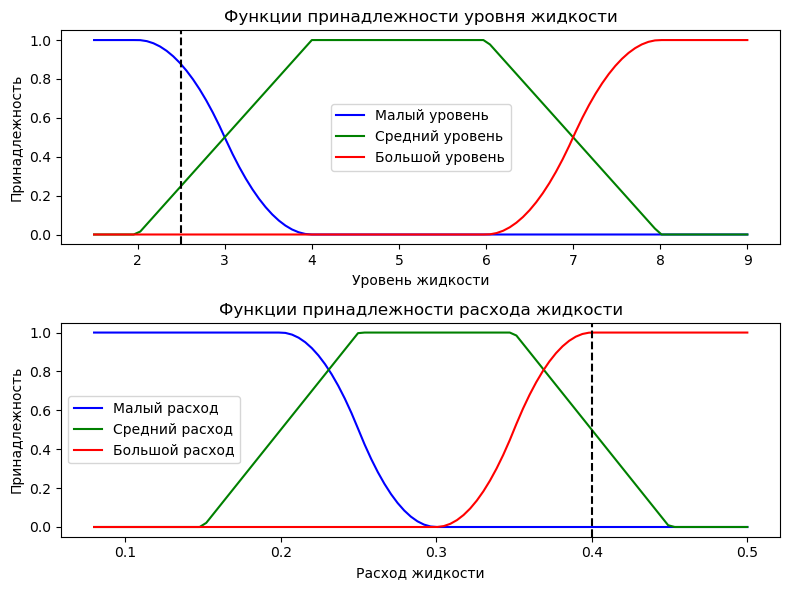

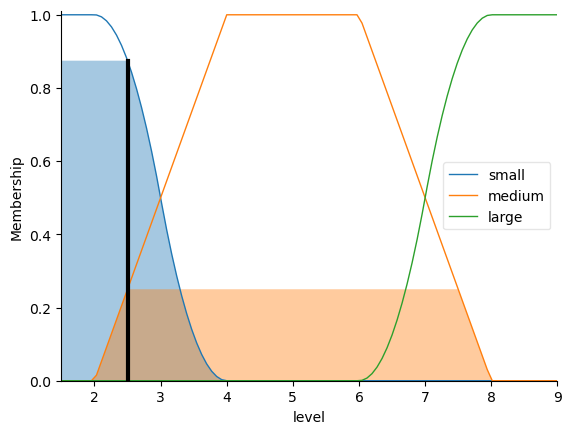

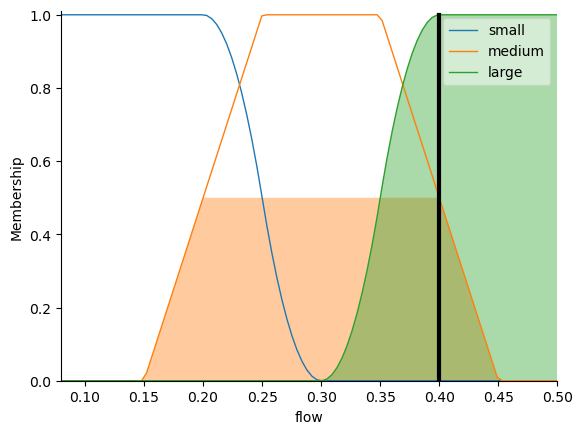

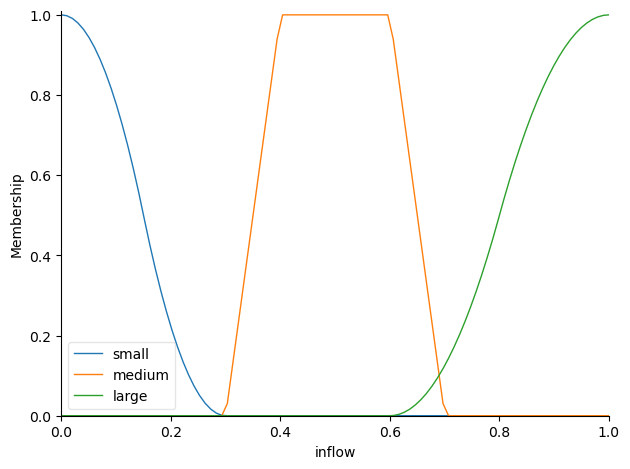

In [16]:
update_ui()
recalculate_inflow(button)